# Random Forest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('/Users/uqhkamel/PhD/Code/AKI_mimiciv/mimic-code-main/mimic-iv/src')
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import sqlite3

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score


from pickle import dump
from dfwiz import dfwiz
from dfwiz import dfwiz_compare

from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import recall_score


# from sklearn.pipeline import Pipeline


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample

import copy

from sklearn import metrics


from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, scale, melt, unmelt, \
                             remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap,get_dates
from utils.pipelines import scale_impute_via_pipeline

In [3]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
pd.set_option("display.max_columns", None)

In [4]:
# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

In [5]:

import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn')
sns.set_theme(style="ticks")
mpl.rcParams['figure.figsize'] = (10,6)

# Title
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 20

# Axes labels
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelweight'] = 'bold'

# Grid and thicks
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
#mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['ytick.left'] = False

# Legend
mpl.rcParams['legend.facecolor'] = 'w'
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['legend.edgecolor'] = 'blue'
mpl.rcParams['legend.borderpad'] = 0.6

# Other
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['scatter.edgecolors'] = None




_________
### upsampler func def

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

class upsampler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X

    def sample(self, X, y = None):
        X = np.array(X)
        y = np.array(y)
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y[y == 0]], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y[y == 1]], y[y == 1]
        else:
            print(X[y[y == 0]].shape)
            X1, y1 = resample(X[y[y == 1]], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y[y == 0]], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  

        return X_out, y_out


_________
### accuracy func def

In [7]:
def confusion_matrix_plot(y, y_pred, y_pred_proba):

    fpr, tpr, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
    score = metrics.roc_auc_score(y,  y_pred_proba[::,1])

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(round(score,2)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()


    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7,7))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
    accuracy = accuracy_score(y, y_pred)

    # print("Accuracy: %.2f%%" % (accuracy * 100.0))


    cr = classification_report(y, y_pred)
    print("\r\n"+"Classification report"+"\r\n")
    print(cr)

    print("\r\n_________________________________________")
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn+fp)
    print("\r\n"+"Specificity"+"\r\n")
    print(round(specificity,2))

    print("\r\n_________________________________________")



In [8]:
from sklearn.utils import resample

def up_sample(X_train_raw, y_train_raw,col_name):

    # upsampling X_train and y_train
    df_upsampled = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True)

    X_minority = df_upsampled[df_upsampled[col_name]==1]
    X_majority = df_upsampled[df_upsampled[col_name]!=1]

    n_samples = X_majority.shape[0]
    X_minority_upsampled = resample(X_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=n_samples,    # to match majority class
                                    random_state=42) # reproducible results

    df_upsampled = pd.concat([X_majority, X_minority_upsampled]).sample(frac=1)

    y_train_out = df_upsampled[[col_name]]
    X_train_out = df_upsampled.drop([col_name], axis=1)

    return X_train_out, y_train_out

_________
### define cross validation function

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold



def param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 5, sample_ratio = 0.2, refit=True, use_error=True, multi_class=False, average_metric='macro'):

    print("This search selects lower indexes of search list if their score is within the error of maximum score.")
    print("Putting parameters for less complicated model on the left side of the grid lists leads to better generalisation. ")
    print(" ")

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    n_train = int(sample_ratio * len(y_train))
    X_train_s, y_train_s  = resample(X_train, y_train, n_samples=n_train, stratify=y_train)

    best_score = {}
    best_params = {}
    for k, v in param_grid.items():
        # best_params[k] = v[int(len(v)/2)-1]
        best_params[k] = v[0]
    best_params_m1 = best_params.copy()
    print("start_params:", best_params)

    score = {}
    score_std = {}

    for i_iter in range(max_iter):
        print("_"*100)
        print("Iteration", i_iter)

        for k, v in param_grid.items():

            best_params1 = best_params.copy()
            del best_params1[k]  

            score[k] = v.copy()
            score_std[k] = v.copy()

            for i_param, val_param in enumerate(v):
                cv_sc = np.zeros(cv)

                for i_cv in range(cv):

                    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_s, y_train_s, test_size=0.2, stratify=y_train_s, shuffle=True) # 80% training and 20% test

                    p1 = copy.deepcopy(pipe)
                    p1.set_params(**best_params1)
                    params2 = {k:val_param}
                    p1.set_params(**params2)

                    p1.fit(X_train2, y_train2.ravel())
                    # X,y = p1.named_steps['resample'].fit_resample(X_test2, y_test2)
                    X,y = X_test2, y_test2
                    # y_pred_proba = p1.predict_proba(X)
                    # cv_sc[i_cv] = metrics.roc_auc_score(y,  y_pred_proba[::,1])
                    y_pred = p1.predict(X)
                    if(multi_class):
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred, average=average_metric)
                    else:
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred)

                    i_cv = i_cv + 1

                score[k][i_param] = cv_sc.mean()
                score_std[k][i_param] = cv_sc.std()

            print("")
            print(k)
            print(v)
            print(score[k])

            best_params[k] = v[np.argmax(score[k])]
            best_score[k] = score[k][np.argmax(score[k])]

            if use_error:
                for i_b in  range(np.argmax(score[k]),-1,-1):
                    err1 = (score_std[k][i_b] + score_std[k][v.index(best_params[k])] ) / 4
                    # print("err1")
                    max_del = max(score[k]) - err1
                    # print( i_b, score[k][i_b], max(score[k]), err1, max_del )
                    if score[k][i_b] >= max_del:
                        best_params[k] = v[i_b]
                        best_score[k] = score[k][i_b]

            print("best_param:",  v[np.argmax(score[k])], "score:", max(score[k]))
            print("selected_param:",  best_params[k], "score:", best_score[k])
            

        
        print("")
        print("best_params =", best_params)
        print("")
        if best_params_m1 == best_params:
            print("")
            print("")
            print("Early stop. No improvement in the last iteration.")
            break
        best_params_m1 = best_params.copy()

    param_graph_plot(score)

    if refit:
        print("Refitting final model...")
        pipeline_final = copy.deepcopy(pipe)
        pipeline_final.set_params(**best_params)
        pipeline_final.fit(X_train, y_train.values.ravel())
    else:
        pipeline_final = None

    return score, best_params, pipeline_final
    

def param_graph_plot(score):
    ax = {}
    fig = {}
    for i, (k, v) in enumerate(score.items()):
        fig[k], ax[k] = plt.subplots()

    for k, v in score.items():
        x = score[k]
        y = v
        ax[k].plot(x,y,"-o", label="Score")
        # ax[k].set_ylim([0.5, 1])
        ax[k].set_title(k)
        ax[k].legend()

________
### Define upsampler

In [10]:

from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.utils import resample


class upsampler(BaseEstimator): 
    def __init__(self):
        return None

    def fit_resample(self, X, y = None):
        X = np.array(X)
        y = np.array(y).ravel()
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y == 0], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y == 1], y[y == 1]
        else:
            X1, y1 = resample(X[y == 1], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y == 0], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  
        return X_out, y_out

________
### Load data and select index

In [11]:
# create a database connection
sqluser = 'uqhkamel'
dbname = 'mimiciv'
schema_name = 'mimic_derived'

In [12]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [13]:
# query = "select * from all_scr_preadmission_75_JOIN"
# data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id','hadm_id'])
query = "select * from all_scr_JOIN"
data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id'])
data.drop('hadm_id', inplace=True, axis=1)

In [14]:
data['ethnicity'] = data['ethnicity'].replace(['OTHER'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNKNOWN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['AMERICAN INDIAN/ALASKA NATIVE'],np.nan)

data = data.fillna(value=np.nan)


In [15]:
data.shape

(39379, 110)

In [16]:
# aki_kdigo = ['aki_kdigo_grade_1','aki_kdigo_grade_2','aki_kdigo_grade_3']

# outcome_var = ['day_detection_kdigo_grade_1','day_detection_kdigo_grade_2','day_detection_kdigo_grade_3']

# outcome_var.append('min_day_rrt_present')

outcome_var = ['day_detection_kdigo_grade_1']

first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [17]:
data[data['min_day_rrt_present']<=1].shape

(194, 110)

In [18]:
outcome_var = []
outcome_var.append('min_day_rrt_present')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [19]:
data[data['ckd']==1].shape

(4514, 110)

In [20]:
data = data[data['ckd']==0]

In [21]:
data[data['kidney_transplant']==1].shape

(82, 110)

In [22]:
data = data[data['kidney_transplant']==0]

In [23]:
# data = data[data['egfr_mdrd_scr']>60]

In [24]:
# data[data.egfr_mdrd_scr<60].shape

In [25]:
data.head(5)

,,aki_kdigo_grade_1,aki_kdigo_grade_2,aki_kdigo_grade_3,day_detection_kdigo_grade_1,day_detection_kdigo_grade_2,day_detection_kdigo_grade_3,aki_mkdigo_grade_1,aki_mkdigo_grade_2,aki_mkdigo_grade_3,day_detection_mkdigo_grade_1,day_detection_mkdigo_grade_2,day_detection_mkdigo_grade_3,age,female,ethnicity,ckd,egfr_epi_scr,egfr_mdrd_scr,kidney_transplant,congestive_heart_failure,diabetes_type2,chronic_kidney_disease,hypertension,obesity_icd,peripheral_vascular_disease,chronic_liver_disease,mild_liver_disease,severe_liver_disease,myocardial_infarct,chronic_pulmonary_disease,aschronic_heart_failure,sepsis,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,wbc_bd_min,wbc_bd_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,glucose_min,glucose_max,sodium_min,sodium_max,potassium_min,potassium_max,pt_min,pt_max,thrombin_min,thrombin_max,ptt_min,ptt_max,inr_min,inr_max,bilirubin_total_min,bilirubin_total_max,egfr_epi_scr_max,egfr_mdrd_scr_max,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,resp_rate_min,resp_rate_max,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,arbs_acei,cyclosporine,bmi,urineoutput_24hr,supplemental_oxygen,invasive_vent,hfnc,non_invasive_vent,tracheostomy,min_day_rrt_present,min_day_rrt_active,weight_admit,weight_min,weight_max,hospital_expire_flag
stay_id,subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30001148,12980335,1,0,0,2.0,9999999.0,9999999.0,1,0,0,2.0,9999999.0,9999999.0,68.0,0,NaN,0.0,77.0,74.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,25.2,32.3,8.5,11.0,160.0,198.0,7.4,11.7,7.4,11.7,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,25.0,27.0,9.0,12.0,NaN,NaN,108.0,111.0,0.6,0.6,119.0,119.0,138.0,138.0,4.2,4.7,13.6,14.9,NaN,NaN,27.3,29.5,1.2,1.3,NaN,NaN,103.0,134.0,64.0,80.0,75.520000,92.0,125.0,108.155172,48.0,76.0,58.620690,3.0,23.0,14.750000,35.33,38.17,36.390000,92.0,100.0,0,0,35.9,205.0,1,0,0,0,0,99999999.0,99999999.0,65.7,65.7,69.9,0
30001656,19609454,0,0,0,9999999.0,9999999.0,9999999.0,1,0,0,2.0,9999999.0,9999999.0,68.0,1,WHITE,0.0,94.0,99.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32.9,37.9,12.4,13.6,245.0,304.0,10.8,14.5,10.8,14.5,3.8,3.8,NaN,NaN,NaN,NaN,9.0,16.0,26.0,26.0,13.0,18.0,7.7,7.7,97.0,99.0,0.5,0.6,83.0,103.0,128.0,137.0,3.5,3.7,11.7,11.7,NaN,NaN,20.1,20.1,1.0,1.0,0.6,0.6,94.0,99.0,69.0,102.0,82.148148,103.0,174.0,138.333333,58.0,107.0,72.000000,11.0,24.0,15.375000,36.33,37.50,36.928571,99.0,100.0,0,0,NaN,375.0,1,1,0,0,0,99999999.0,99999999.0,71.0,71.0,75.7,0
30003125,16165135,0,0,0,9999999.0,9999999.0,9999999.0,0,0,0,9999999.0,9999999.0,9999999.0,60.0,0,WHITE,0.0,103.0,115.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,38.0,38.0,13.0,13.0,150.0,150.0,9.9,9.9,9.9,9.9,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,26.0,26.0,14.0,14.0,8.4,8.4,103.0,103.0,0.7,0.7,141.0,141.0,139.0,139.0,3.6,3.6,13.2,13.2,NaN,NaN,28.4,28.4,1.2,1.2,NaN,NaN,103.0,115.0,59.0,95.0,73.230769,104.0,153.0,128.500000,47.0,73.0,60.433333,11.0,26.0,19.653846,36.89,37.39,37.127143,94.0,100.0,1,0,NaN,150.0,1,0,0,0,0,99999999.0,99999999.0,73.2,73.2,73.2,0
30007175,15171885,1,0,0,2.0,9999999.0,9999999.0,1,1,0,1.0,9999999.0,9999999.0,86.0,1,ASIAN,0.0,67.0,68.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,31.5,33.2,10.7,10.9,163.0,184.0,6.2,7.1,6.2,7.1,4.0,4.0,NaN,NaN,NaN,NaN,14.0,18.0,20.0,25.0,13.0,18.0,8.1,8.6,81.0,84.0,0.5,0.8,93.0,189.0,109.0,120.0,3.4,7.5,12.5,12.5,NaN,NaN,29.8,29.8,1.2,1.2,0.8,0.8,67.0,68.0,59.0,106.0,78.964286,90.0,169.0,126.884615,28.0,124.0,60.653846,11.0,27.0,15.714286,36.50,37.06,36.724000,93.0,100.0,0,0,NaN,300.0,1,0,0,0,0,99999999.0,99999999.0,46.4,46.4,46.5,0
30011624,14833679,0,0,0,9999999.0,9999999.0,9999999.0,0,0,0,9999999.0,9999999.0,9999999.0,91.0,0,NaN,0.0,83.0,106.0,0,0,0,0,1,0,

In [26]:
# data.dropna(axis=1, thresh = int(0.3*data.shape[0]), inplace=True)

In [27]:
# pd.set_option('display.max_rows', None)

In [28]:
# data.isna().sum()/len(data)*100

In [29]:
# prediction_window = 3

# data.loc[(((data['aki_kdigo_grade_1']== 1)| (data['aki_kdigo_grade_2']== 1) | (data['aki_kdigo_grade_3']==1)) \
#     &( (data['day_detection_kdigo_grade_1']<=prediction_window)| (data['day_detection_kdigo_grade_2']<=prediction_window) | (data['day_detection_kdigo_grade_3']<=prediction_window)) \
#         |(data['min_day_rrt_present']<= prediction_window)), 'outcome'] = 1


# data.loc[data.outcome.isna(),'outcome']=0

In [30]:
prediction_window = 3

data.loc[(( (data['aki_kdigo_grade_1']== 1)) \
    &( (data['day_detection_kdigo_grade_1']<=prediction_window))), 'outcome'] = 1


data.loc[data.outcome.isna(),'outcome']=0

In [31]:
drop_X   = [
'day_detection_kdigo_grade_1',
'day_detection_kdigo_grade_2',
'day_detection_kdigo_grade_3',
'day_detection_mkdigo_grade_1',
'day_detection_mkdigo_grade_2',
'day_detection_mkdigo_grade_3',
'min_day_rrt_active',
'min_day_rrt_present',
'ckd',
'chronic_kidney_disease'
]
# CRP and vomit_nausea as they had mostly empty

data.drop(drop_X, inplace=True, axis=1)

## Missingness percentage

In [32]:
perc = 20 # remove rows with NaN is 80 or more in each row
min_count =  int(((100-perc)/100)*data.shape[0])
data.dropna(axis=1, thresh = min_count, inplace=True)

In [33]:
# data.reset_index().drop_duplicates(subset=['stay_id','subject_id','hadm_id']).set_index(['stay_id','subject_id','hadm_id'])

In [34]:
# # remove unpopulated columns
# data.pipe(sort)\
#               .pipe(replace_inf).pipe(drop_empty)

In [35]:
# split by column type
data_num = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical')

data_cat = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical')

In [36]:
# data_cat = data_cat.pipe(filter_categorical, cutoff=20, plot=False)\
#                                             .pipe(sort).pipe(spy, title='Before onehot', figsize=[12,4])\
#                                             .fillna('other').pipe(onehot)
# data_cat = data_cat.fillna('other').pipe(onehot)
data_cat = pd.get_dummies(data_cat,prefix=[''], prefix_sep='', columns = ['ethnicity'], drop_first=True)

In [37]:
# processed = pd.merge(data_num, data_cat, left_index=True, right_index=True)
processed = pd.merge(data_num, data_cat, left_index=True, right_index=True, how='inner')

In [38]:
processed2 = processed.copy()
processed.drop(['egfr_epi_scr','egfr_mdrd_scr'], inplace=True, axis=1)


In [39]:
(processed[processed['aki_kdigo_grade_3']==1].shape[0])/processed.shape[0]

0.005797319680770968

In [40]:
(processed[processed['aki_kdigo_grade_1']==1].shape[0])

4825

In [41]:
processed.shape

(26564, 90)

In [42]:
# AKI_1_df = (processed[processed['outcome']==1])
# AKI_0_df = (processed[processed['outcome']==0])

# columns = ['egfr_epi_scr_max', 'egfr_mdrd_scr_max','creatinine_max','creatinine_min']



# dfwiz_compare(AKI_1_df, AKI_0_df, columns=columns, label = ['AKi_1', 'AKI_0'])

In [43]:
# AKI_1_df.hospital_expire_flag.value_counts()

In [44]:
# AKI_0_df.hospital_expire_flag.value_counts()

In [45]:
drop_X   = [
    'aki_kdigo_grade_1',
    'aki_mkdigo_grade_1',

    'aki_kdigo_grade_2',
    'aki_mkdigo_grade_2',

    'aki_kdigo_grade_3',
    'aki_mkdigo_grade_3',
    'is_mdrd',
    'hospital_expire_flag'

]
 
select_y = ['outcome']

processed_X = processed.pipe(filter_regex, drop_X+select_y)
processed_Y = processed.filter(regex='|'.join(select_y))
raw_Y = data_num.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y)).pipe(remove_outliers)
df_y = raw_Y[select_y]


df_X, df_y = match(processed_X, df_y)

In [46]:
df_y.outcome.value_counts()

0.0    21739
1.0     4825
Name: outcome, dtype: int64

In [47]:
4825/df_y.shape[0]

0.181636801686493

In [48]:
X, y = df_X, df_y

from sklearn.model_selection import train_test_split

X_train_0, X_valid, y_train_0, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y) # 

X_train, X_test, y_train, y_test = train_test_split(X_train_0, y_train_0, test_size=0.25, random_state=42, shuffle=True, stratify=y_train_0) #0.25 *0.8 = 0.2 for test and 0.75*0.8 = 0.60 for train


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)


______________________________________________________________________________________________________________________________________________________
Total number of records: 
2895
Columns:
['aki_kdigo_grade_1', 'aki_kdigo_grade_2', 'aki_kdigo_grade_3', 'aki_mkdigo_grade_2', 'aki_mkdigo_grade_3', 'age', 'female', 'egfr_epi_scr', 'chronic_liver_disease', 'egfr_mdrd_scr', 'kidney_transplant', 'outcome', 'hypertension', 'obesity_icd', 'congestive_heart_failure', 'diabetes_type2', 'peripheral_vascular_disease', 'creatinine_min', 'aki_mkdigo_grade_1', 'severe_liver_disease', 'myocardial_infarct', 'chronic_pulmonary_disease', 'aschronic_heart_failure', 'sepsis', 'mild_liver_disease', 'creatinine_max', 'egfr_epi_scr_max', 'egfr_mdrd_scr_max', 'hospital_expire_flag', 'cyclosporine', 'supplemental_oxygen', 'invasive_vent', 'hfnc', 'non_invasive_vent', 'tracheostomy', 'arbs_acei', 'chloride_max', 'bicarbonate_min', 'bicarbonate_max', 'chloride_min', 'bun_min', 'bun_max', 'sodium_max', 'sodium_

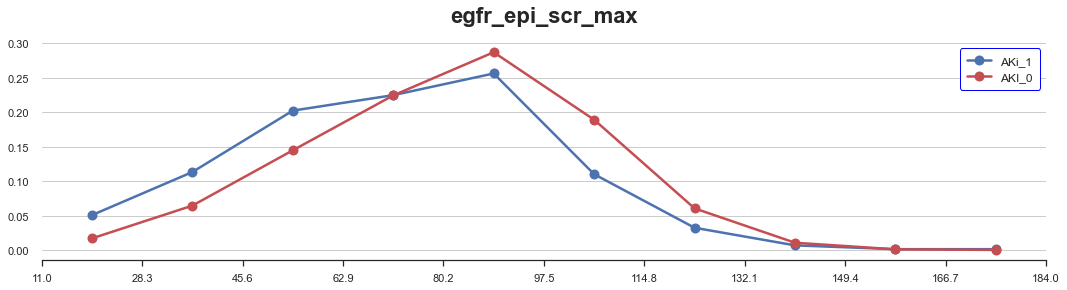


______________________________________________________________________________________________________________________________________________________

   egfr_mdrd_scr_max
Jensen-Shanon distance: 0.11


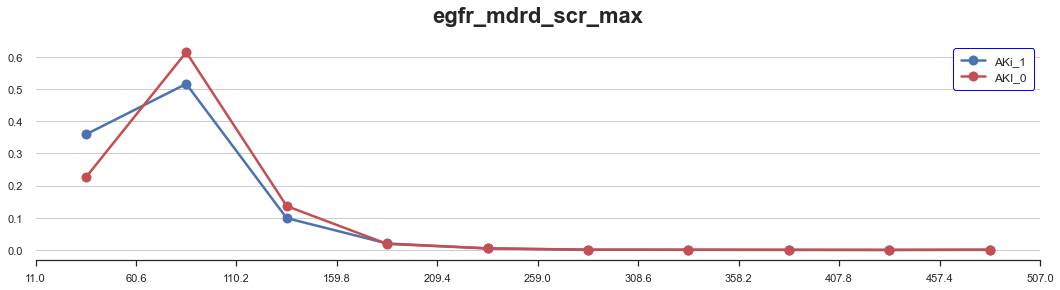


______________________________________________________________________________________________________________________________________________________

   creatinine_max
Jensen-Shanon distance: 0.13


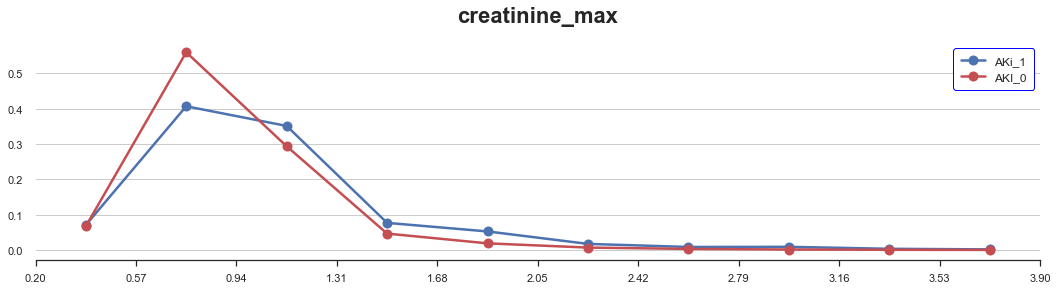


______________________________________________________________________________________________________________________________________________________

   creatinine_min
Jensen-Shanon distance: 0.10


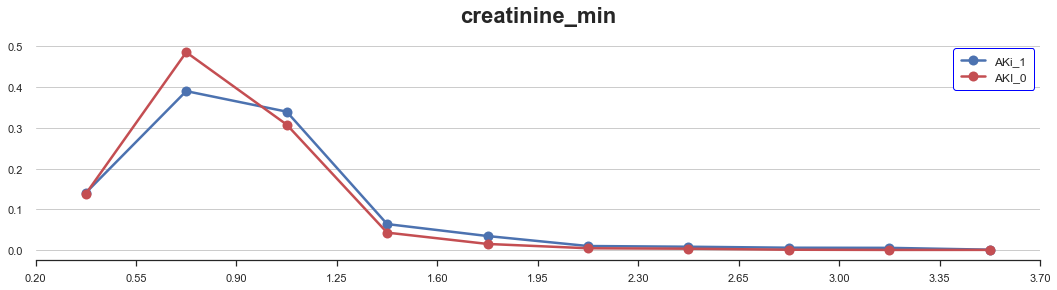


______________________________________________________________________________________________________________________________________________________



In [49]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

train_df = pd.merge(X_train_copy, y_train_copy, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))
train_df.drop([col for col in train_df.columns if 'drop' in col], axis=1, inplace=True)

processed_copy = processed2.copy()
processed_copy = pd.merge(processed_copy, train_df, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))
processed_copy.drop([col for col in processed_copy.columns if 'drop' in col], axis=1, inplace=True)




AKI_1_df = (processed_copy[processed_copy['outcome']==1])
AKI_0_df = (processed_copy[processed_copy['outcome']==0])

columns = ['egfr_epi_scr_max', 'egfr_mdrd_scr_max','creatinine_max','creatinine_min']



dfwiz_compare(AKI_1_df, AKI_0_df, columns=columns, label = ['AKi_1', 'AKI_0'])

In [50]:
AKI_1_df.hospital_expire_flag.value_counts()

0    2559
1     336
Name: hospital_expire_flag, dtype: int64

In [51]:
AKI_1_df.query("hospital_expire_flag==1").shape[0]/AKI_1_df.shape[0]

0.11606217616580311

In [52]:
AKI_0_df.hospital_expire_flag.value_counts()

0    12452
1      591
Name: hospital_expire_flag, dtype: int64

In [53]:
AKI_0_df.query("hospital_expire_flag==1").shape[0]/AKI_0_df.shape[0]

0.04531166142758568

In [54]:
# X_train, y_train = df_X, df_y
# X_train, y_train = up_sample(X_train, y_train,'outcome')
X_train,  y_train = [
    df.reset_index(drop=True)
    for df in up_sample(X_train, y_train,'outcome')]

In [55]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
# X_train, y_train = rus.fit_resample(X_train, y_train)

In [56]:
# dfwiz_compare(X_train,X_test, label=['df_train','df_test'])

In [57]:
df_y.value_counts()

outcome
0.0        21739
1.0         4825
dtype: int64

In [58]:
4825/(df_y.shape[0])

0.181636801686493

In [59]:
df_y.query("outcome==1").sum()/df_y.shape[0]

outcome    0.181637
dtype: float64

___________________
### Define pipeline

In [60]:
import lightgbm as lgbm  # standard alias

pipe = Pipeline(steps=[
# ('resample', upsampler()),
('scaler', MinMaxScaler()),
('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
('model', lgbm.LGBMClassifier(n_jobs=-1, n_estimators=300))
])

___________________
### Cross validation search

In [61]:
# ########### **************************************8
# # Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   


# param_grid ={'model__num_leaves': [6, 10, 20, 50], 
#              'model__min_child_samples': [100, 200, 300, 400, 500], 
#              'model__min_child_weight': [1e-5,  1e-2,  1,  1e2,  1e4],
#              'model__subsample' : [0.2, 0.5, 0.8], 
#              'model__reg_alpha': [0, 1e-1, 1, 5,  10, 50, 100],
#              'model__reg_lambda': [0, 1e-1, 1,  10,  50, 100]}






# score, best_params, pipeline_final = param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 4, sample_ratio = 0.1, refit=False, use_error=True)

# # dump(pipeline_final , open('pipeline_final_LGBM.pkl', 'wb'))

In [62]:
# import lightgbm as lgbm  # standard alias

# pipe = Pipeline(steps=[
# # ('resample', upsampler()),
# ('scaler', MinMaxScaler()),
# ('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan, sample_posterior=True)),
# ('model', lgbm.LGBMClassifier(n_jobs=-1))
# ])

In [63]:
# from skopt import BayesSearchCV
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score


# bayes_cv_tuner = BayesSearchCV(
#     estimator = pipe
#     ,search_spaces = {
#         'model__n_estimators': (100,200,300,400),
#         'model__num_leaves': (6, 10, 20, 50), 
#         'model__min_child_samples': (100, 200, 300, 400, 500), 
#         'model__min_child_weight': (1e-5,  1e-2,  1,  1e2,  1e4),
#         'model__subsample' : (0.2, 0.5, 0.8), 
#         'model__reg_alpha': (0, 1e-1, 1, 5,  10, 50, 100),
#         'model__reg_lambda': (0, 1e-1, 1,  10,  50, 100)

#     }, 
#     cv = StratifiedKFold(
#         n_splits=5,
#         shuffle=True,
#     ),
#     # cv=3,
#     n_jobs = 3,
#     n_iter = 10,   
#     verbose = 0,
#     scoring='f1'
# )

# sample_ratio = 0.1
# n_samples = int(len(X_train)*sample_ratio)
# X, y = resample(X_train.values, y_train.values, n_samples=n_samples, stratify=y_train.values, random_state=10)
# result = bayes_cv_tuner.fit(X, y.ravel())
# # print(result.score(X_test, y_test))
# print(result.best_params_)
# print(result.best_score_)

__________
### Fitting Pipeline one time



______________________________________________________________________________________________________________________________________________________

Train Accuracy:



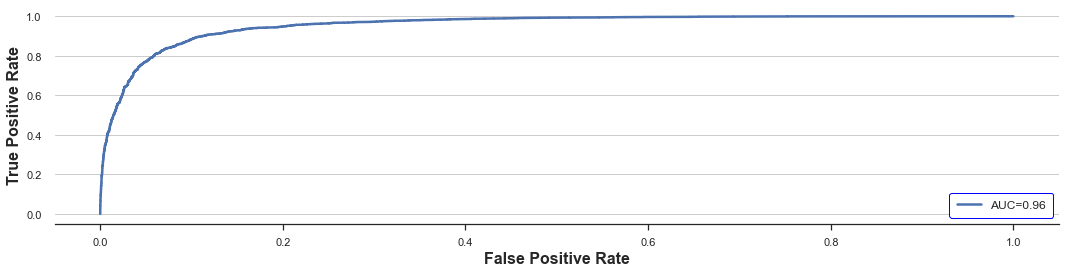

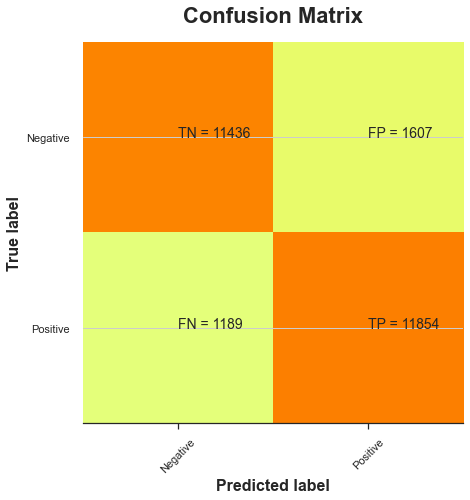


Classification report

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89     13043
         1.0       0.88      0.91      0.89     13043

    accuracy                           0.89     26086
   macro avg       0.89      0.89      0.89     26086
weighted avg       0.89      0.89      0.89     26086


_________________________________________

Specificity

0.88

_________________________________________


In [64]:
# manual params setting
# best_params = {'model__num_leaves': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 0.01, 'model__subsample': 0.8, 'model__reg_alpha': 0, 'model__reg_lambda': 0.1}
# best_params = {'model__n_estimators': 400,'model__num_leaves': 20, 'model__min_child_samples': 300, 'model__min_child_weight': 0.01, 'model__subsample': 0.2, 'model__reg_alpha': 1, 'model__reg_lambda': 50}
# best_params = {'model__min_child_samples': 300, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__num_leaves': 20, 'model__reg_alpha': 1.0, 'model__reg_lambda': 50, 'model__subsample': 0.2}
best_params = {'model__n_estimators': 400,'model__num_leaves': 50, 'model__min_child_samples': 100, 'model__min_child_weight': 1, 'model__subsample': 0.2, 'model__reg_alpha': 50, 'model__reg_lambda': 0}
# Or get parameters from search above
best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train)*sample_ratio)
X, y = resample(X_train.values, y_train.outcome.values, n_samples=n_samples, stratify=y_train.values, random_state=10)
pipeline_final = copy.deepcopy(pipe)
pipeline_final.set_params(**best_params2)
pipeline_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = pipeline_final.predict(X)
y_pred_proba = pipeline_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(pipeline_final, open('pipe_rf.pkl', 'wb'))


__________
### Test accuracy

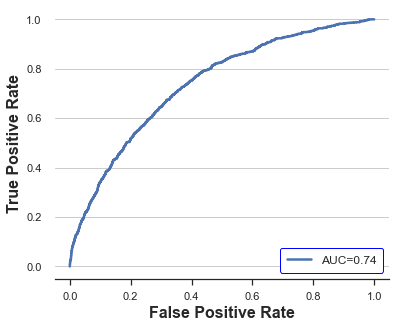

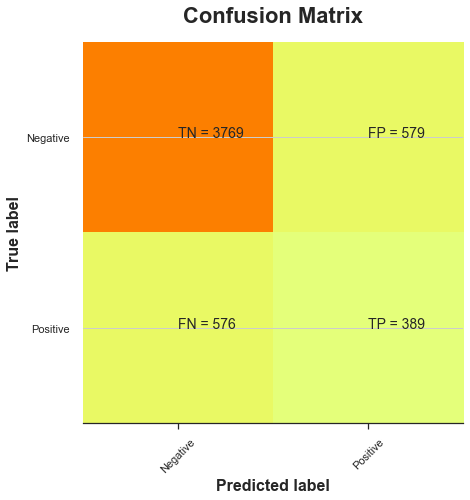


Classification report

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      4348
         1.0       0.40      0.40      0.40       965

    accuracy                           0.78      5313
   macro avg       0.63      0.63      0.63      5313
weighted avg       0.78      0.78      0.78      5313


_________________________________________

Specificity

0.87

_________________________________________


In [65]:

# X,y = pipeline_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (6,5)
clf_threshold = 0.59

X,y = X_valid.values, y_valid.values

y_pred = pipeline_final.predict(X)
y_pred_proba = pipeline_final.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= clf_threshold).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


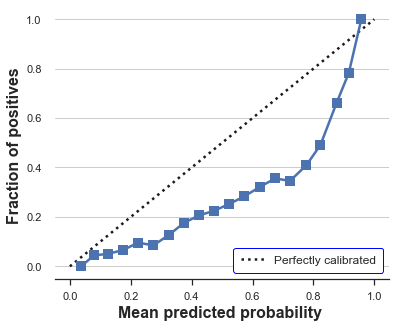

In [66]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

y_prob = pipeline_final.predict_proba(X_valid)[:, 1]
prob_true, prob_pred = calibration_curve(y_valid, y_prob, n_bins=20)

disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

In [ ]:
from sklearn.feature_selection import mutual_info_classif


def scale_impute(df, pipe):
    data_scaled = pipe.named_steps['scaler'].transform(df)
    df_scaled = pd.DataFrame(data_scaled, columns=df.columns)
    data_imputed = pipe.named_steps['imputer'].transform(df_scaled)
    df_result = pd.DataFrame(data_imputed, columns=df.columns)
    return df_result

X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

X_train_copy = scale_impute(X_train_copy, pipeline_final)


X_MI = np.array(X_train_copy[['creatinine_max','egfr_epi_scr_max']])
y_MI = np.array(y_train_copy.outcome)

mi = mutual_info_classif(X_MI,y_MI)
mi

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y, y_pred)

In [ ]:
df_y.value_counts()

In [ ]:
fpr_XGB_grade123, tpr_XGB_grade123, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
%store fpr_XGB_grade123
%store tpr_XGB_grade123

In [ ]:
%store -r fpr_RF_grade123
%store -r tpr_RF_grade123

%store -r fpr_ANN_grade123
%store -r tpr_ANN_grade123

%store -r fpr_LR_grade123
%store -r tpr_LR_grade123

In [ ]:
# plt.rcParams["figure.figsize"] = (7.5,6)
plt.rcParams["figure.figsize"] = (9,8)
mpl.rcParams['lines.linewidth'] = 1.5
plt.plot(fpr_XGB_grade123,tpr_XGB_grade123,label="XGB (AUC=0.90)")
plt.plot(fpr_RF_grade123,tpr_RF_grade123,label="RF    (AUC=0.88)")
plt.plot(fpr_LR_grade123,tpr_LR_grade123,label="LR    (AUC=0.87)")
plt.plot(fpr_ANN_grade123,tpr_ANN_grade123,label="ANN (AUC=0.86)")
plt.plot([0, 1], [0, 1], marker=".", alpha=0.4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
final_estimator = pipeline_final._final_estimator

In [ ]:
importances = final_estimator.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.rcParams["figure.figsize"] = (12,20)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
def scale_impute(df, pipe):
    data_scaled = pipe.named_steps['scaler'].transform(df)
    df_scaled = pd.DataFrame(data_scaled, columns=df.columns)
    data_imputed = pipe.named_steps['imputer'].transform(df_scaled)
    df_result = pd.DataFrame(data_imputed, columns=df.columns)
    return df_result

## SHAP

In [ ]:
import dalex as dx

exp = dx.Explainer(pipeline_final, X_train, y_train)

In [ ]:
exp.model_parts().plot()

In [ ]:
row_number = 1
exp.predict_parts(X_test.iloc[[row_number]], N=100).plot(min_max=[0,1])

In [ ]:
import shap

X_test_t = scale_impute_via_pipeline(df=X_test,pipe=pipeline_final)
shap.initjs()
explainer = shap.TreeExplainer(final_estimator)
shap_values = explainer.shap_values(X_test_t)

In [ ]:
df_X.temperature_min.describe()

In [ ]:
df_X.temperature_min.median()

In [ ]:
shap.dependence_plot("age",shap_values[1], X_test_t)

In [ ]:
shap.summary_plot(shap_values[1], X_test_t)

In [ ]:

X_train_t = scale_impute_via_pipeline(X_train, pipeline_final)
shap.initjs()
# X_sampled = df_X_train_imp.sample(100, random_state=10)
explainer = shap.TreeExplainer(final_estimator)
shap_values = explainer.shap_values(X_train_t)

In [ ]:
shap.dependence_plot("age",shap_values[1], X_train)

In [ ]:
shap.summary_plot(shap_values[1], X_train_t,max_display=50)

In [ ]:
import shap

X_test_t = scale_impute(df=X_test,pipe=pipeline_final)
shap.initjs()
explainer = shap.TreeExplainer(pipeline_final._final_estimator)
shap_values = explainer.shap_values(X_test_t)
shap.summary_plot(shap_values[1], X_test_t, max_display=50)

In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X_train)

In [ ]:
# compute SHAP values

# compute SHAP values
X_test_t = scale_impute(df=X_test,pipe=pipeline_final)
shap.initjs()
explainer = shap.Explainer(pipeline_final._final_estimator, X_test_t)
shap_values = explainer(X_test_t,check_additivity=False)
shap.plots.beeswarm(shap_values,max_display=50)

In [ ]:
row_number=1
single_observation = X_train.iloc[[row_number]].values[0]
X_train_t = scale_impute(df=X_train,pipe=pipeline_final)

# data = shap_values.data[row_number]
# data = single_observation

shap.initjs()
explainer = shap.Explainer(final_estimator,X_train_t, check_additivity=False)
# shap_values = explainer(X_train_t)
shap_values = explainer(single_observation)



class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names
        



shap_object = ShapObject(base_values = shap_values.base_values[row_number],
                         values = shap_values.values[row_number],
                         feature_names = single_observation.columns,
                         data = single_observation)

                         

shap.waterfall_plot(shap_object, max_display=10)


## Histograms

In [ ]:
# combining X_test,y_test and y_pred in one dataset
# del(df_test_all)
df_test_all = X_test.copy()
df_test_all['y_actual'] = y_test
df_test_all['y_pred'] = y_pred
# df_test_all

In [ ]:
# labeling the category of error

pd.options.mode.chained_assignment = None  # To suppress a warning for commands below 

df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 1: # True positive 2
          df_test_all['error_category'][i] = 2
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 0: # False negative 3
          df_test_all['error_category'][i] = 3

# df_test_all

In [ ]:
df_TN = df_test_all[df_test_all.error_category==0]
df_FP = df_test_all[df_test_all.error_category==1]

df_TP = df_test_all[df_test_all.error_category==2]
df_FN = df_test_all[df_test_all.error_category==3]

In [ ]:
import shap

df_TN_shap = df_TN.drop(['y_pred','y_actual','error_category'], axis=1)
df_TN_shap = scale_impute_via_pipeline(df_TN_shap)
shap.initjs()
# X_sampled = df_X_train_imp.sample(100, random_state=10)
explainer = shap.TreeExplainer(final_estimator)
shap_values = explainer.shap_values(df_TN_shap)
shap.summary_plot(shap_values[1], df_TN_shap)

In [ ]:
error_df = {"df_TN":df_TN, "df_FP":df_FP, "df_TP":df_TP, "df_FN":df_FN}
# error_df = {"df_FP":df_FP, "df_FN":df_FN}

import shap
shap.initjs()

for k,df in error_df.items():
    df_shap = df.drop(['y_pred','y_actual','error_category'], axis=1)
    df_shap = scale_impute_via_pipeline(df_shap, final_estimator)

    explainer = shap.TreeExplainer(final_estimator)
    shap_values = explainer.shap_values(df_shap)
    print("SHAP: "+k)
    shap.summary_plot(shap_values[1], df_shap)

In [ ]:
df_FN.shape

In [ ]:
common_processed = processed2.copy()
common_FN = pd.merge(df_FN, common_processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))
common_FN.drop([col for col in common_FN.columns if 'drop' in col], axis=1, inplace=True)

common_FN.aki_kdigo_grade_1.value_counts()

In [ ]:
common_FN.aki_kdigo_grade_2.value_counts()

In [ ]:
common_FN.aki_kdigo_grade_3.value_counts()

## Dalex

In [ ]:
import dalex as dx

exp = dx.Explainer(pipeline_final, X_train, y_train)

In [ ]:
exp.model_performance(model_type='classification').plot(geom='roc')

In [ ]:
exp.model_parts().plot(max_vars=30)

In [ ]:
row_number = 1
exp.predict_parts(X_test.iloc[[row_number]], N=100).plot(min_max=[0,1])

In [ ]:
y_test.iloc[[row_number]]

In [ ]:
y_pred[row_number]

In [ ]:
import dalex as dx

error_df = {"df_TN":df_TN, "df_FP":df_FP, "df_TP":df_TP, "df_FN":df_FN}
# error_df = {"df_FP":df_FP, "df_FN":df_FN}

for k,df in error_df.items():
    df_shap = df.drop(['y_pred','y_actual','error_category'], axis=1)

    row_number = 1
    print("SHAP: "+k)
    exp.predict_parts(df_shap.iloc[[row_number]], N=100).plot(min_max=[0,1])

In [ ]:
df_shap.iloc[[281]]

## Break-down plot using Dalex

In [ ]:
import random
random.seed(42)
rand_list = random.sample(range(0, df_FP.shape[0]), 10)

clf_threshold = 0.38
import dalex as dx

# error_df = {"df_TN":df_TN, "df_FP":df_FP, "df_TP":df_TP, "df_FN":df_FN}
error_df = {"df_FP":df_FP}

for k,df in error_df.items():
    df_shap = df.drop(['y_pred','y_actual','error_category'], axis=1)

    for row_number in rand_list:
        print("Using DALEX on false positive instance with row number: "+str(row_number))
        exp.predict_parts(df_shap.iloc[[row_number]], N=100).plot(min_max=[0,1], max_vars=30, baseline=clf_threshold)

## SHAP plot using Dalex

In [ ]:
import random
random.seed(42)
rand_list = random.sample(range(0, df_FP.shape[0]), 10)

clf_threshold = 0.38
import dalex as dx

# error_df = {"df_TN":df_TN, "df_FP":df_FP, "df_TP":df_TP, "df_FN":df_FN}
error_df = {"df_FP":df_FP}

for k,df in error_df.items():
    df_shap = df.drop(['y_pred','y_actual','error_category'], axis=1)

    for row_number in rand_list:
        print("Using DALEX SHAP on false positive instance with row number: "+str(row_number))
        exp.predict_parts(df_shap.iloc[[row_number]], N=100, type='shap').plot(min_max=[0,1], max_vars=30, baseline=clf_threshold)

In [ ]:
df_FP.creatinine_max.describe()

In [ ]:
df_TN.creatinine_min.describe()

In [ ]:
import random
random.seed(42)
rand_list = random.sample(range(0, df_TN.shape[0]), 10)


import dalex as dx

# error_df = {"df_TN":df_TN, "df_FP":df_FP, "df_TP":df_TP, "df_FN":df_FN}
error_df = {"df_TN":df_TN}

for k,df in error_df.items():
    df_shap = df.drop(['y_pred','y_actual','error_category'], axis=1)

    for row_number in rand_list:
        print("Using DALEX on true negative instance with row number: "+str(row_number))
        exp.predict_parts(df_shap.iloc[[row_number]], N=100).plot(min_max=[0,1], max_vars=30, baseline=clf_threshold)

## Global Dalex

In [ ]:
#Merge the DataFrames
# common_processed = processed2.copy()
common_processed = processed.copy()
common_FP = pd.merge(df_FP, common_processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))

#Drop the duplicate columns
common_FP.drop([col for col in common_FP.columns if 'drop' in col], axis=1, inplace=True)


#Merge the DataFrames
common_TN = pd.merge(df_TN, common_processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))

#Drop the duplicate columns
common_TN.drop([col for col in common_TN.columns if 'drop' in col], axis=1, inplace=True)

#Merge the DataFrames
common_TP = pd.merge(df_TP, common_processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))

#Drop the duplicate columns
common_TP.drop([col for col in common_TP.columns if 'drop' in col], axis=1, inplace=True)


#Merge the DataFrames
common_FN = pd.merge(df_FN, common_processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))

#Drop the duplicate columns
common_FN.drop([col for col in common_FN.columns if 'drop' in col], axis=1, inplace=True)


#Merge the DataFrames
common_test_all = pd.merge(df_test_all, common_processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))

#Drop the duplicate columns
common_test_all.drop([col for col in common_test_all.columns if 'drop' in col], axis=1, inplace=True)

In [ ]:
common_FP.head(2)

In [ ]:
common_FP.shape

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr", y="age", data=common_FP, kind="hex", joint_kws={'color':'#66ffcc'})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)


In [ ]:
(common_FP[common_FP.egfr_epi_scr<60].shape[0])/(common_FP.shape[0])

In [ ]:
(common_FP[common_FP.egfr_epi_scr<60].shape[0])/(processed.shape[0])

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr", y="age", data=common_TN, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
(common_TN[common_TN.egfr_epi_scr<60].shape[0])/(common_TN.shape[0])

In [ ]:
(common_FP[common_FP.egfr_epi_scr<60].shape[0])/(processed.shape[0])

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr", y="age", data=common_TP, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr", y="age", data=common_FN, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr_max", y="age", data=common_FN, kind="hex", joint_kws={'color':"#ffe6ff"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr", y="age", data=common_FP, kind="hex", joint_kws={'color':'#66ffcc'})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)


In [ ]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,6)
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
sns.histplot(data=common_FP, x=common_FP.egfr_epi_scr, common_norm=False, bins=50, stat="percent");
plt.title("Kernel Density Function");

In [ ]:
import seaborn as sns

plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.rcParams["figure.figsize"] = (10,6)
sns.histplot(data=common_FP, x=common_FP.egfr_epi_scr, hue='age', common_norm=False, bins=50, stat="percent");
plt.title("Kernel Density Function");

In [ ]:
# Creating bins
x_min = np.min(common_FP.egfr_epi_scr)
x_max = np.max(common_FP.egfr_epi_scr)
  
y_min = np.min(common_FP.age)
y_max = np.max(common_FP.age)
  
x_bins = np.linspace(x_min, x_max, 50)
y_bins = np.linspace(y_min, y_max, 20)

fig, ax = plt.subplots(figsize =(10, 7))
plt.hist2d(common_FP.egfr_epi_scr, common_FP.age, bins=[x_bins, y_bins])
plt.axvline(90, 0,10, linestyle='--', color = 'blue', linewidth=1.5)
plt.title("2D histogram of false positives")
ax.set_xlabel('minimum EGFR') 
ax.set_ylabel('Age') 

# show plot
plt.tight_layout() 
plt.show()

In [ ]:
# Creating bins
x_min = np.min(common_FP.egfr_epi_scr)
x_max = np.max(common_FP.egfr_epi_scr)
  
y_min = np.min(common_FP.age)
y_max = np.max(common_FP.age)
  
x_bins = np.linspace(x_min, x_max, 50)
y_bins = np.linspace(y_min, y_max, 20)

fig, ax = plt.subplots(figsize =(10, 7))
plt.hexbin(common_FP.egfr_epi_scr, common_FP.age, bins=50)
plt.axvline(90, 0,10, linestyle='--', color = 'blue', linewidth=1.5)
plt.title("2D histogram of false positives")
ax.set_xlabel('minimum EGFR') 
ax.set_ylabel('Age') 

# show plot
plt.tight_layout() 
plt.show()

In [ ]:
for i, col in enumerate(common_FP.columns):
    plt.figure(i)
    sns.histplot(data=common_FP, x=col, bins=50, stat='percent', common_norm=False);
    plt.title(col);

In [ ]:
df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1

In [ ]:
# get data for True negative and  False positive and compare their distribution.
# It plots the distribution and prints Jensen-Shanon distance.
# from functions_compare_distribution import compare_hist_df
from dfwiz import dfwiz, dfwiz_compare
# healthy patients
TN = df_test_all.query("error_category == 0")[X_test.columns] # True negative
FP = df_test_all.query("error_category == 1")[X_test.columns] # False positive

if len(TN) == 0 or len(FP) == 0:
    print("Error! one of the dataframes are empty")
else:
    # compare_hist_df(TN, FP) # plot distributions and output Jensen-Shanon distance.
    dfwiz_compare(FP, TN,label=['FP', 'TN'])

In [ ]:
for i, col in enumerate(df_test_all.columns):
    plt.figure(i)
    sns.kdeplot(data=df_test_all, x=col, hue='error_category', bins=50, stat='density', common_norm=False);
    plt.title(col);

In [ ]:
for i, col in enumerate(df_test_all.columns):
    plt.figure(i)
    sns.histplot(data=df_test_all, x=col, hue='error_category', common_norm=False, bins=50, stat="percent");
    plt.title("Kernel Density Function");

In [ ]:
sns.histplot(data=df_FP, x=df_FP.egfr_epi_scr, hue='age', common_norm=False, bins=50, stat="density");
plt.title("Kernel Density Function");

In [ ]:
for i, col in enumerate(df_test_all.columns):
    plt.figure(i)
    sns.histplot(data=df_test_all, x=col, hue='error_category', bins=len(df_test_all), stat='density', element="step", fill=False, cumulative=True,common_norm=False);
    plt.title("Cumulative distribution function");

## Decision Tree on validation set to differentiate between 

In [ ]:
# labeling the category of error
del(df_test_all)


# X_test_scaled_array = pipeline_final.named_steps['scaler'].transform(X_test)
# X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns)
# X_test_imp_array = pipeline_final.named_steps['imputer'].transform(X_test_scaled)
# df_test_all = pd.DataFrame(X_test_imp_array, columns=X_test.columns)


X_test_imp_array = pipeline_final.named_steps['imputer'].transform(X_test)
df_test_all = pd.DataFrame(X_test_imp_array, columns=X_test.columns)


# df_test_all['y_actual'] = y_valid.values.ravel()
df_test_all['y_actual'] = y_test.values.ravel()
df_test_all['y_pred'] = y_pred

pd.options.mode.chained_assignment = None  # To suppress a warning for commands below 

df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 1: # True positive 2
          df_test_all['error_category'][i] = 2
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 0: # False negative 3
          df_test_all['error_category'][i] = 3

In [ ]:
df_FP_TN = df_test_all.loc[(df_test_all['error_category'] == 0) | (df_test_all['error_category'] == 1)]
df_FP_FN = df_test_all.loc[(df_test_all['error_category'] == 1) | (df_test_all['error_category'] == 3)]

In [ ]:
df_FP_TN.error_category.value_counts()

In [ ]:
df_FP_FN.error_category.value_counts()

In [ ]:
# train a descision tree to predict the model error in negative cases ('True negative' vs 'False positive'). 
from sklearn import tree



class_names = ['TN', 'FP']
df1 = df_FP_TN.copy()
X1 = df1[X_test.columns]
X1
y1 =  df1[['error_category']]
clf = tree.DecisionTreeClassifier(max_depth = 5 , class_weight='balanced', random_state=42, criterion="gini", min_impurity_decrease = 0.01)
clf = clf.fit(X1, y1)

# plot the tree
plt.figure(figsize=(20,12))
tree.plot_tree(clf,
               feature_names = list(X1.columns), 
               rounded=True, 
               filled = True,
               proportion = True,
               class_names = class_names);


In [ ]:
# train a descision tree to predict the model error in negative cases ('True negative' vs 'False positive'). 
from sklearn import tree



class_names = ['FP', 'FN']
df1 = df_FP_FN.copy()
X1 = df1[X_test.columns]
X1
y1 =  df1[['error_category']]
clf = tree.DecisionTreeClassifier(max_depth = 5 , class_weight='balanced', random_state=42, criterion="gini", min_impurity_decrease = 0.01)
clf = clf.fit(X1, y1)

# plot the tree
plt.figure(figsize=(20,12))
tree.plot_tree(clf,
               feature_names = list(X1.columns), 
               rounded=True, 
               filled = True,
               proportion = True,
               class_names = class_names);


In [ ]:
X_train_new = X_train.loc[~(y_error_t==1)]
y_train_new = y_train.loc[~(y_error_t==1)]

X_valid_new = X_valid.loc[~(y_error_v==1)]
y_valid_new = y_valid.loc[~(y_error_v==1)]

In [ ]:
# X_train_new, y_train_new = up_sample(X_train_new, y_train_new,'outcome')
X_train_new, y_train_new = up_sample(X_train, y_train,'outcome')